In [1]:
# ============================================================
# CSINet-test-domainAware 
# - Evaluates domain-aware CSINet for:
#       * cross_type in {"in2out", "out2in"}
#       * test scenarios: Indoor / Outdoor 
#       * both source path (no adapter) and target path (adapter)
# - Updates the SAME mutable CSV: results/nmse_results.csv
# ============================================================

from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import os

# ============================================================
# CONFIG
# ============================================================

dst_path    = "./dataset"     # where DATA_Htestin.mat and DATA_Htestout.mat are
ckpt_dir    = "checkpoints"   # where training saved the domain-aware checkpoints
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

batch_size  = 200
encoded_dim = 512   # MUST match training
residual_num = 2    # MUST match training
base_channels = 8   # adapt if you used different capacity per domain


Device: cpu


In [2]:
# ============================================================
# 0. GLOBAL CONSTANTS & MODEL DEFINITIONS
# ============================================================

# ===================== GLOBAL CONSTANTS =====================

img_height   = 32
img_width    = 32
img_channels = 2
img_total    = img_height * img_width * img_channels

IMG_C, IMG_H, IMG_W = img_channels, img_height, img_width


# ===================== ADAPTER MODULE =====================

class ConvAdapter(nn.Module):
    """
    Lightweight residual adapter:
        x ↦ x + Up(LeakyReLU(Down(x)))

    - channels: number of feature channels in the layer.
    - reduction: bottleneck factor (e.g. 4 or 8).
    """
    def __init__(self, channels: int, reduction: int = 4):
        super().__init__()
        hidden = max(1, channels // reduction)

        self.down = nn.Conv2d(channels, hidden, kernel_size=1)
        self.up   = nn.Conv2d(hidden, channels, kernel_size=1)
        self.act  = nn.LeakyReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        y = self.down(x)
        y = self.act(y)
        y = self.up(y)
        return residual + y


# ===================== DECODER COMPONENTS =====================

class ResidualBlockDecoded(nn.Module):
    """
    Residual block with configurable width.
    For indoor we can keep base_channels small (sparser),
    for outdoor we can use larger base_channels (more capacity).
    """
    def __init__(self, base_channels: int = 8):
        super().__init__()
        c1 = base_channels
        c2 = base_channels * 2

        self.conv1 = nn.Conv2d(2, c1, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(c1)

        self.conv2 = nn.Conv2d(c1, c2, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(c2)

        self.conv3 = nn.Conv2d(c2, 2, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(2)

        self.act   = nn.LeakyReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shortcut = x
        y = self.act(self.bn1(self.conv1(x)))
        y = self.act(self.bn2(self.conv2(y)))
        y = self.bn3(self.conv3(y))
        y = self.act(shortcut + y)
        return y


# ===================== ENCODER WITH ADAPTER =====================

class CsiNetEncoder(nn.Module):
    """
    Shared encoder with optional adapter:
        x (B,2,32,32)
          → conv_in + BN + LeakyReLU
          → [optional ConvAdapter]
          → flatten
          → fc_enc
          → z (B, encoded_dim)

    - In Phase 1 (source domain): use_adapter=False (no adapters used)
    - In Phase 2 (target domain): use_adapter=True (adapters ON)
    """
    def __init__(self, encoded_dim: int = 512, adapter_reduction: int = 4):
        super().__init__()
        self.encoded_dim = encoded_dim

        # Backbone (to be frozen in Phase 2)
        self.conv_in = nn.Conv2d(2, 2, kernel_size=3, padding=1)
        self.bn_in   = nn.BatchNorm2d(2)
        self.act     = nn.LeakyReLU(inplace=True)

        self.fc_enc  = nn.Linear(img_total, encoded_dim)

        # Adapter (small trainable module for domain adaptation)
        self.adapter = ConvAdapter(channels=2, reduction=adapter_reduction)

    def forward(self, x: torch.Tensor, use_adapter: bool = False) -> torch.Tensor:
        """
        x: (B, 2, 32, 32)
        use_adapter:
            - False: backbone only (Phase 1 / source domain inference)
            - True : backbone + adapter (Phase 2 / target domain path)
        """
        x = self.act(self.bn_in(self.conv_in(x)))

        if use_adapter:
            x = self.adapter(x)

        B = x.size(0)
        x = x.view(B, -1)           # (B, img_total)
        z = self.fc_enc(x)          # (B, encoded_dim)
        return z


# ===================== DECODER (PER-DOMAIN HEAD) =====================

class CsiNetDecoder(nn.Module):
    """
    Domain-specific decoder: dense + residual blocks + conv_out.
    - base_channels controls capacity (e.g., 8 for indoor, 16 for outdoor).
    """
    def __init__(
        self,
        encoded_dim: int = 512,
        residual_num: int = 2,
        base_channels: int = 8
    ):
        super().__init__()
        self.encoded_dim  = encoded_dim
        self.residual_num = residual_num

        self.fc_dec = nn.Linear(encoded_dim, img_total)
        self.res_blocks = nn.ModuleList(
            [ResidualBlockDecoded(base_channels=base_channels) for _ in range(residual_num)]
        )
        self.conv_out = nn.Conv2d(2, 2, kernel_size=3, padding=1)
        self.sigmoid  = nn.Sigmoid()

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        B = z.size(0)
        x = self.fc_dec(z)                         # (B, img_total)
        x = x.view(B, img_channels, img_height, img_width)
        for block in self.res_blocks:
            x = block(x)
        x = self.sigmoid(self.conv_out(x))        # (B, 2, 32, 32)
        return x

In [3]:
# ============================================================
# 1. HELPERS: LOAD DATA, NMSE, LABELS
# ============================================================

def load_single_domain(kind: str) -> np.ndarray:
    """
    kind: 'indoor' or 'outdoor'
    Returns X with shape (N, 2, 32, 32) as float32.
    Handles the flattened HT case (N, img_total) or (img_total, N).
    """
    if kind == "indoor":
        mat_path = os.path.join(dst_path, "DATA_Htestin.mat")
    elif kind == "outdoor":
        mat_path = os.path.join(dst_path, "DATA_Htestout.mat")
    else:
        raise ValueError("kind must be 'indoor' or 'outdoor'")

    mat = sio.loadmat(mat_path)
    H = mat["HT"]  # 2-D in your case

    if H.ndim != 2:
        raise ValueError(f"Unexpected H.ndim={H.ndim}, expected 2")

    n1, n2 = H.shape
    if n2 == img_total:
        X = H.reshape(-1, img_channels, img_height, img_width)
    elif n1 == img_total:
        X = H.T.reshape(-1, img_channels, img_height, img_width)
    else:
        raise ValueError(
            f"Cannot infer shape from HT with shape {H.shape}; "
            f"neither dimension equals img_total={img_total}"
        )

    return X.astype(np.float32)



def nmse_angle_delay_db(X: np.ndarray, X_hat: np.ndarray) -> float:
    """
    X, X_hat: (N, 2, 32, 32), values in [0,1].
    Uses same normalization as CSINet:
       h = (real-0.5) + j*(imag-0.5)
    Returns NMSE in dB in angle–delay domain.
    """
    N = X.shape[0]

    x_real = X[:, 0, :, :].reshape(N, -1)
    x_imag = X[:, 1, :, :].reshape(N, -1)
    x_cmplx = x_real - 0.5 + 1j * (x_imag - 0.5)

    y_real = X_hat[:, 0, :, :].reshape(N, -1)
    y_imag = X_hat[:, 1, :, :].reshape(N, -1)
    y_cmplx = y_real - 0.5 + 1j * (y_imag - 0.5)

    power = np.sum(np.abs(x_cmplx) ** 2, axis=1)
    mse   = np.sum(np.abs(x_cmplx - y_cmplx) ** 2, axis=1)
    nmse  = np.mean(mse / power)
    nmse_db = 10 * np.log10(nmse)
    return float(nmse_db)


def test_label(name: str) -> str:
    """Readable column label for CSV."""
    name = name.lower()
    if "indoor" in name:
        return "Indoor"
    elif "outdoor" in name:
        return "Outdoor"
    else:
        return name.capitalize()


In [4]:
# ============================================================
# 2. EVALUATION FUNCTION (ONE COMBO)
# ============================================================

def is_relevant_combo(cross_type: str, scenario_type: str, eval_role: str) -> bool:
    """
    Return True only for semantically meaningful evaluations:
      - in2out:   source on indoor,  target on outdoor
      - out2in:   source on outdoor, target on indoor
    Everything else (e.g., target on source) → False.
    """
    if cross_type == "in2out":
        if scenario_type == "indoor"  and eval_role == "source":
            return True
        if scenario_type == "outdoor" and eval_role == "target":
            return True
    elif cross_type == "out2in":
        if scenario_type == "outdoor" and eval_role == "source":
            return True
        if scenario_type == "indoor"  and eval_role == "target":
            return True
    return False


def eval_domainaware_global(cross_type: str, scenario_type: str):
    """
    Evaluate ONE global domain-aware model for a given cross_type on a scenario.

    cross_type:  'in2out' or 'out2in'
    scenario_type: 'indoor', 'outdoor'

    Uses:
      in2out:
        - Indoor  → source path (no adapter)
        - Outdoor → target path (adapter)
      out2in:
        - Indoor  → target path (adapter)
        - Outdoor → source path (no adapter)
    """

    # --------- resolve src/tgt names and routing rules ----------
    if cross_type == "in2out":
        src_name, tgt_name = "indoor", "outdoor"
        path_for_indoor  = "source"
        path_for_outdoor = "target"
    elif cross_type == "out2in":
        src_name, tgt_name = "outdoor", "indoor"
        path_for_indoor  = "target"
        path_for_outdoor = "source"
    else:
        raise ValueError("cross_type must be 'in2out' or 'out2in'")

    print("\n" + "="*60)
    print(f"[EVAL] DomainAware global model: {cross_type} ({src_name} → {tgt_name})")
    print(f"[EVAL] Scenario = {scenario_type}")
    print("="*60)

    # --------- build model & load checkpoint ----------
    encoder = CsiNetEncoder(encoded_dim=encoded_dim).to(device)
    decoder_src = CsiNetDecoder(encoded_dim=encoded_dim,
                                residual_num=residual_num,
                                base_channels=base_channels).to(device)
    decoder_tgt = CsiNetDecoder(encoded_dim=encoded_dim,
                                residual_num=residual_num,
                                base_channels=base_channels).to(device)

    ckpt_path = os.path.join(
        ckpt_dir,
        f"csinet_domainaware_phase2_adapters_{src_name}_to_{tgt_name}.pt"
    )
    print("[Load] checkpoint:", ckpt_path)
    ckpt = torch.load(ckpt_path, map_location=device)

    encoder.load_state_dict(ckpt["encoder_state_dict"])
    decoder_src.load_state_dict(ckpt["decoder_src_state_dict"])
    decoder_tgt.load_state_dict(ckpt["decoder_tgt_state_dict"])

    encoder.eval(); decoder_src.eval(); decoder_tgt.eval()

    # --------- evaluation per scenario ----------
    def forward_path(X: np.ndarray, path: str) -> np.ndarray:
        """
        X: (N, 2, 32, 32)
        path: 'source' or 'target'
        """
        x_t = torch.from_numpy(X).float().to(device)
        with torch.no_grad():
            if path == "source":
                z = encoder(x_t, use_adapter=False)
                x_hat_t = decoder_src(z)
            else:  # 'target'
                z = encoder(x_t, use_adapter=True)
                x_hat_t = decoder_tgt(z)
        return x_hat_t.cpu().numpy()

    if scenario_type == "indoor":
        X_in = load_single_domain("indoor")
        path = path_for_indoor
        X_hat_in = forward_path(X_in, path)
        nmse_db = nmse_angle_delay_db(X_in, X_hat_in)
    
        X_plot     = X_in
        X_hat_plot = X_hat_in

    elif scenario_type == "outdoor":
        X_out = load_single_domain("outdoor")
        path = path_for_outdoor
        X_hat_out = forward_path(X_out, path)
        nmse_db = nmse_angle_delay_db(X_out, X_hat_out)
    
        X_plot     = X_out
        X_hat_plot = X_hat_out
            
    else:
        raise ValueError(f"Unknown scenario_type: {scenario_type}")

    print(f"[RESULT] NMSE (angle–delay) = {nmse_db:.2f} dB")

    # =====================================================
    # Heatmap comparison: original vs reconstructed |H|
    # =====================================================
    
    n_show = min(6, X_plot.shape[0])          # in case dataset smaller than 6
    idxs = np.arange(n_show)                  # or np.random.choice(X_plot.shape[0], n_show, replace=False)
    
    plt.figure(figsize=(2*n_show, 4))
    
    for i, idx in enumerate(idxs):
        # original magnitude in angle–delay
        H_orig = np.abs(X_plot[idx, 0, :, :] - 0.5 + 1j * (X_plot[idx, 1, :, :] - 0.5))
        # reconstructed magnitude
        H_rec  = np.abs(X_hat_plot[idx, 0, :, :] - 0.5 + 1j * (X_hat_plot[idx, 1, :, :] - 0.5))
    
        # ---------- ORIGINAL ----------
        ax = plt.subplot(2, n_show, i + 1)
        plt.imshow(H_orig.T, origin="lower", aspect="auto")
        plt.title(f"Orig #{idx}")
        plt.xlabel("Angle index")
        plt.ylabel("Delay index")
        ax.set_xticks([])
        ax.set_yticks([])
    
        # ---------- RECONSTRUCTED ----------
        ax = plt.subplot(2, n_show, i + 1 + n_show)
        plt.imshow(H_rec.T, origin="lower", aspect="auto")
        plt.title(f"Recon #{idx}")
        plt.xlabel("Angle index")
        plt.ylabel("Delay index")
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.suptitle(
        f"Angle–Delay Domain Heatmaps — {scenario_type} (model: domainaware_{cross_type})",
        y=1.02,
        fontsize=12
    )
    
    plt.tight_layout()
    fig_name = f"heatmaps_{scenario_type}_domainaware_{cross_type}.png"
    plt.savefig(os.path.join(results_dir, fig_name), dpi=200, bbox_inches="tight")
    plt.show()

    # --------- write to CSV: ONE row per cross_type ----------
    csv_path    = os.path.join(results_dir, "nmse_results.csv")
    scenario_col = test_label(scenario_type)          # 'Indoor', 'Outdoor'
    row_label    = f"domainaware_{cross_type}"        # e.g. 'domainaware_in2out'

    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path, index_col=0)
    else:
        df = pd.DataFrame()

    df.loc[row_label, scenario_col] = nmse_db
    df.to_csv(csv_path)

    print("[CSV] Updated:")
    print(df)

    return nmse_db



[EVAL] DomainAware global model: in2out (indoor → outdoor)
[EVAL] Scenario = indoor
[Load] checkpoint: checkpoints\csinet_domainaware_phase2_adapters_indoor_to_outdoor.pt
[RESULT] NMSE (angle–delay) = -9.04 dB


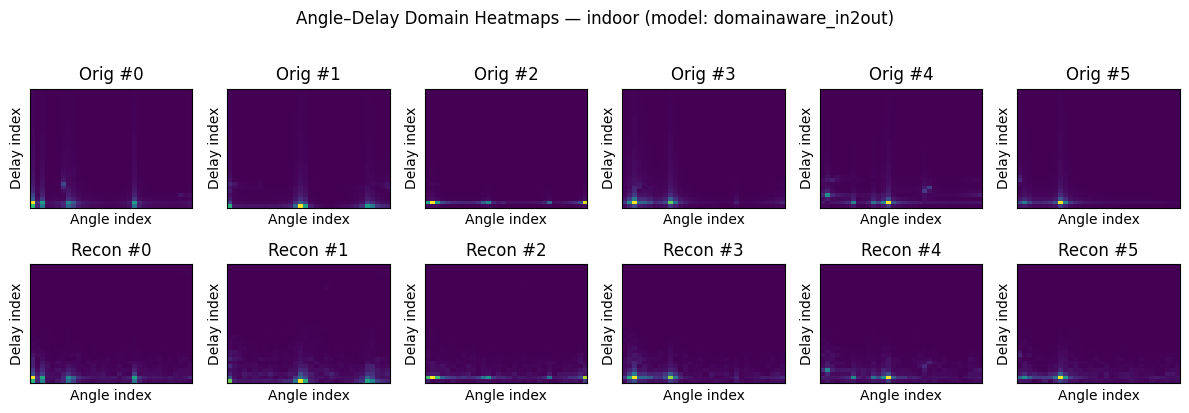

[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006621
finetune_in2out      3.840464 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464285 -2.523215
replay_out2in       -8.243590 -6.201051
domainaware_in2out  -9.039474 -4.504227
domainaware_out2in  -6.404637 -8.173368

[EVAL] DomainAware global model: in2out (indoor → outdoor)
[EVAL] Scenario = outdoor
[Load] checkpoint: checkpoints\csinet_domainaware_phase2_adapters_indoor_to_outdoor.pt
[RESULT] NMSE (angle–delay) = -4.50 dB


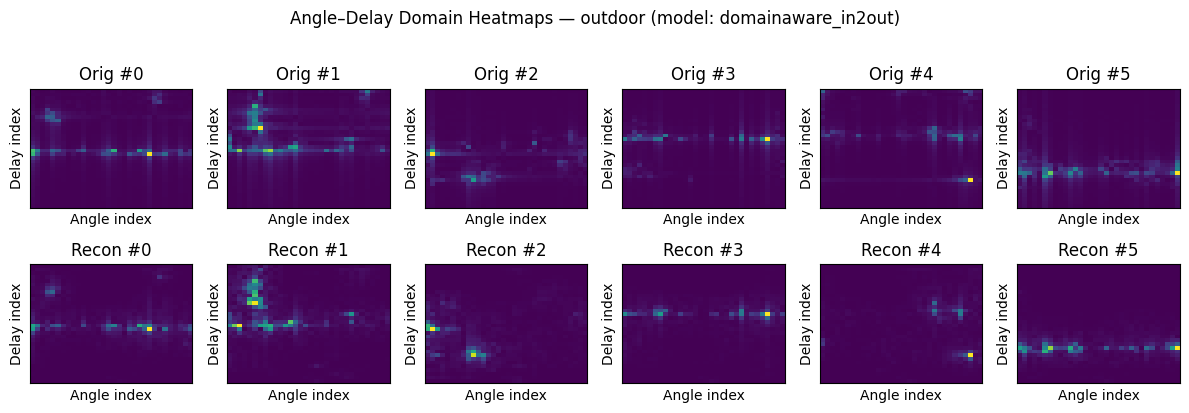

[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006621
finetune_in2out      3.840464 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464285 -2.523215
replay_out2in       -8.243590 -6.201051
domainaware_in2out  -9.039474 -4.504227
domainaware_out2in  -6.404637 -8.173368

[EVAL] DomainAware global model: out2in (outdoor → indoor)
[EVAL] Scenario = indoor
[Load] checkpoint: checkpoints\csinet_domainaware_phase2_adapters_outdoor_to_indoor.pt
[RESULT] NMSE (angle–delay) = -6.40 dB


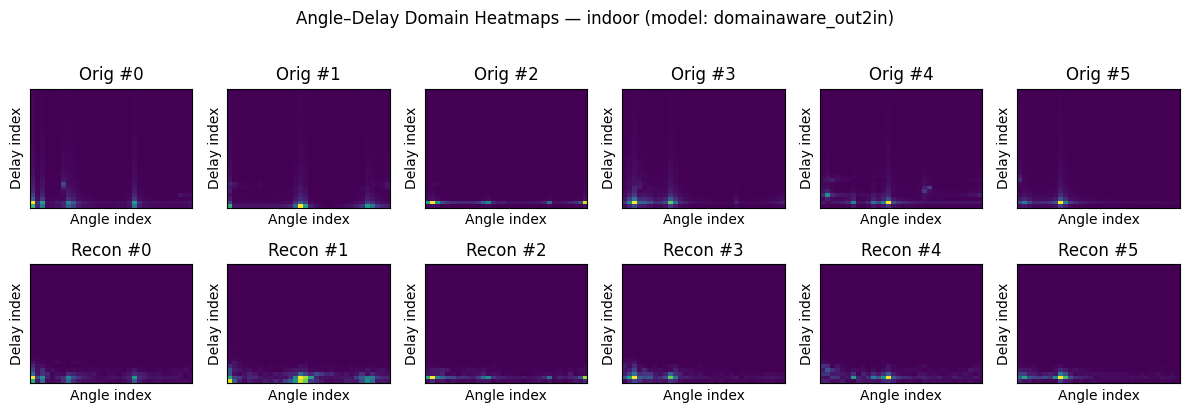

[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006621
finetune_in2out      3.840464 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464285 -2.523215
replay_out2in       -8.243590 -6.201051
domainaware_in2out  -9.039474 -4.504227
domainaware_out2in  -6.404637 -8.173368

[EVAL] DomainAware global model: out2in (outdoor → indoor)
[EVAL] Scenario = outdoor
[Load] checkpoint: checkpoints\csinet_domainaware_phase2_adapters_outdoor_to_indoor.pt
[RESULT] NMSE (angle–delay) = -8.17 dB


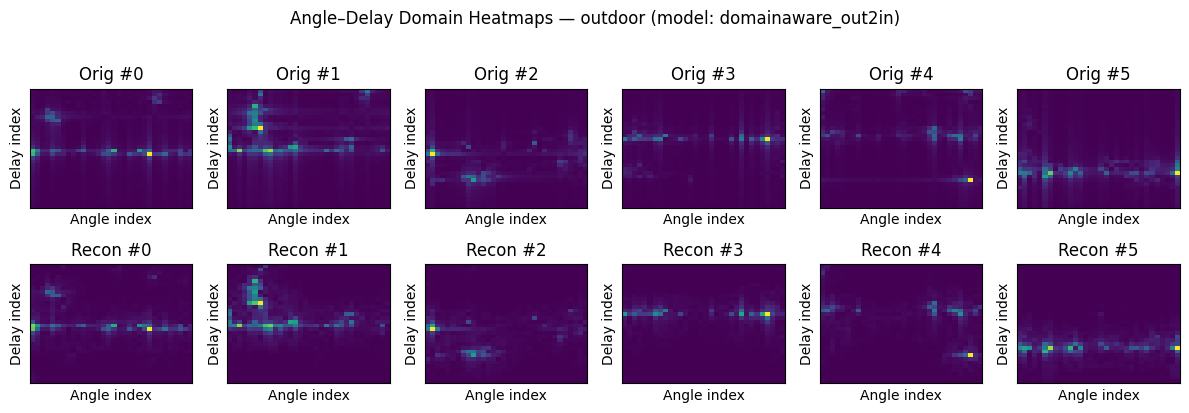

[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006621
finetune_in2out      3.840464 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464285 -2.523215
replay_out2in       -8.243590 -6.201051
domainaware_in2out  -9.039474 -4.504227
domainaware_out2in  -6.404637 -8.173368

All domain-aware evaluations (global model) finished.


In [5]:
# ============================================================
# 3. RUN ALL COMBINATIONS
# ============================================================

for cross_type in ["in2out", "out2in"]:
    for scenario_type in ["indoor", "outdoor"]:
        eval_domainaware_global(cross_type, scenario_type)

print("\nAll domain-aware evaluations (global model) finished.")